In [1]:
# Download Trained model

from file_downloader import FileDownloader

downloader = FileDownloader(data_directory='../data')

url = "https://mf-data-analytics.s3.eu-west-1.amazonaws.com/nyc_crime_category_random_forest_model_180_18.pkl"
filename = "nyc_crime_category_random_forest_model_180_18.pkl"
model_file_path = downloader.download_file(url, filename)


File downloaded successfully and saved to ../data/nyc_crime_category_random_forest_model_180_18.pkl


In [2]:
# check for required file

import os
from pathlib import Path

DATA_FILE_PATH = '../data/NYPD_Complaint_Data_Historic_Cleaned_Reduced_Merged.csv'

file_path = Path(DATA_FILE_PATH)

# Check if the file exists
if file_path.exists():
    print(f"File found: {file_path}")
else:
    print(f"File not found: {file_path}. Please ensure the file is downloaded correctly.")

File found: ../data/NYPD_Complaint_Data_Historic_Cleaned_Reduced_Merged.csv


Model loaded from ../data/nyc_crime_category_random_forest_model_180_18.pkl


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   17.2s finished


Accuracy: 0.4048
Classification Report:


/Users/markfinlay/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/markfinlay/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/markfinlay/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                          precision    recall  f1-score   support

       Drug and Alcohol-Related Offenses       0.00      0.00      0.00       677
            Family and Personal Offenses       0.33      0.25      0.28     93209
              Fraud and Financial Crimes       0.00      0.00      0.00      3651
     Miscellaneous and Specific Offenses       0.36      0.00      0.00     40589
            Negligence and Careless Acts       0.00      0.00      0.00        38
                         Property Crimes       0.38      0.00      0.00     29818
Public Order and Administrative Offenses       0.40      0.00      0.00     35945
                       Theft and Larceny       0.41      0.70      0.52    133822
                                 Traffic       0.65      0.01      0.03      7309
                          Violent Crimes       0.43      0.58      0.49    130277
          Weapons and Dangerous Offenses       0.00      0.00      0.00      1302

              

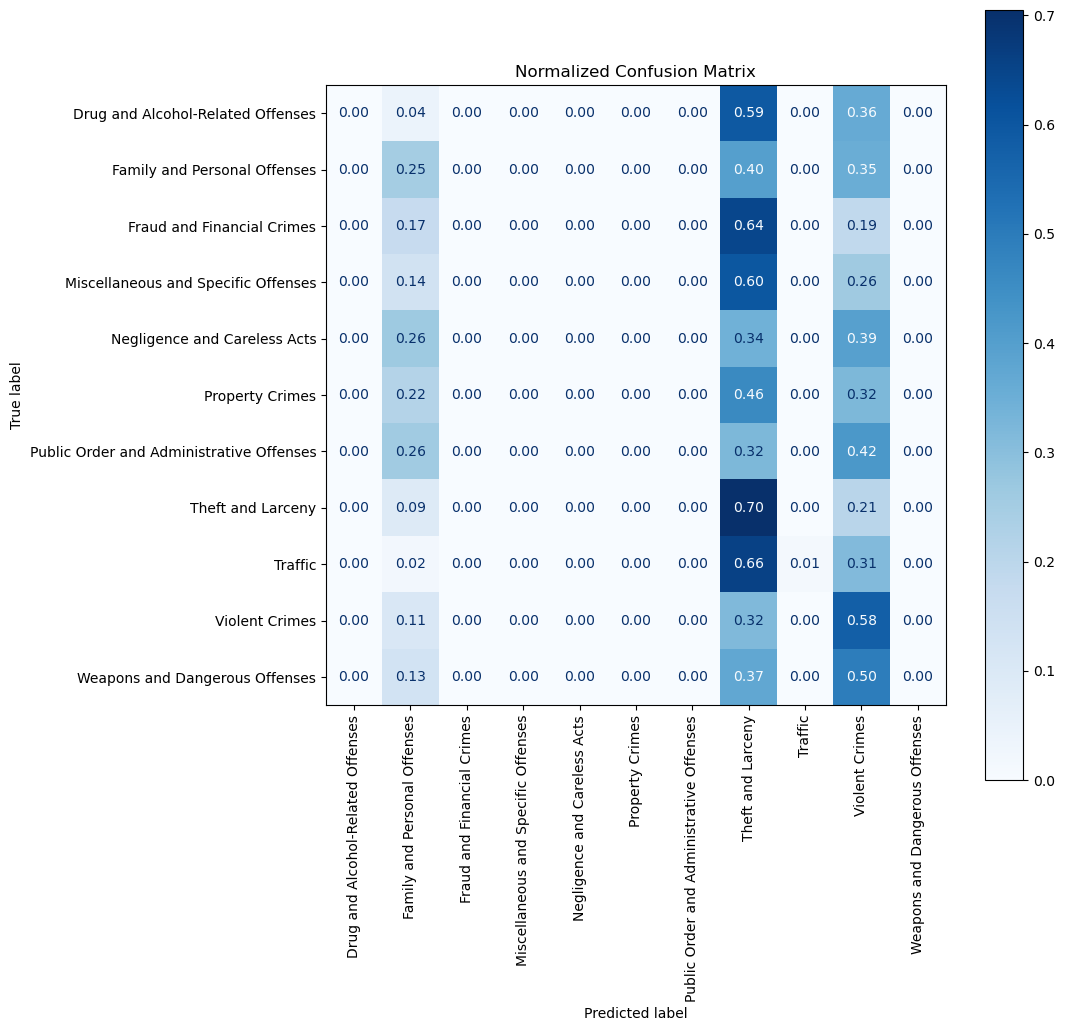

In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nyc_crime_category_random_forest_model import NycCrimeCategoryRandomForestModel

# Initialize the model with optional parameters so we can retrieve Test Data
model = NycCrimeCategoryRandomForestModel(
    random_state=42,
    test_size=0.30,
    n_estimators=30,
    max_depth=3,
    drop_columns=['OFNS_DESC', 'OFNS_DESC_Severity_Score'],
    target_column='Crime_Category',
    model_filename='',
    verbose_level=1
)

model.load_data(DATA_FILE_PATH)
model.preprocess_data()
model.split_data()

X_test = model.X_test

model.load_model(model_file_path)
y_pred = model.predict(X_test)

# Assuming you have the true labels from the test set (y_test)
# If not, you may need to split the data beforehand or ensure you have the true labels.
y_test = model.y_test

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=model.label_encoder.classes_))

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by row (i.e., by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=model.label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.xticks(rotation=90)
plt.title('Normalized Confusion Matrix')
plt.show()



In [4]:
# matrix provides a detailed view of how well the model performs for each class.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   17.1s finished


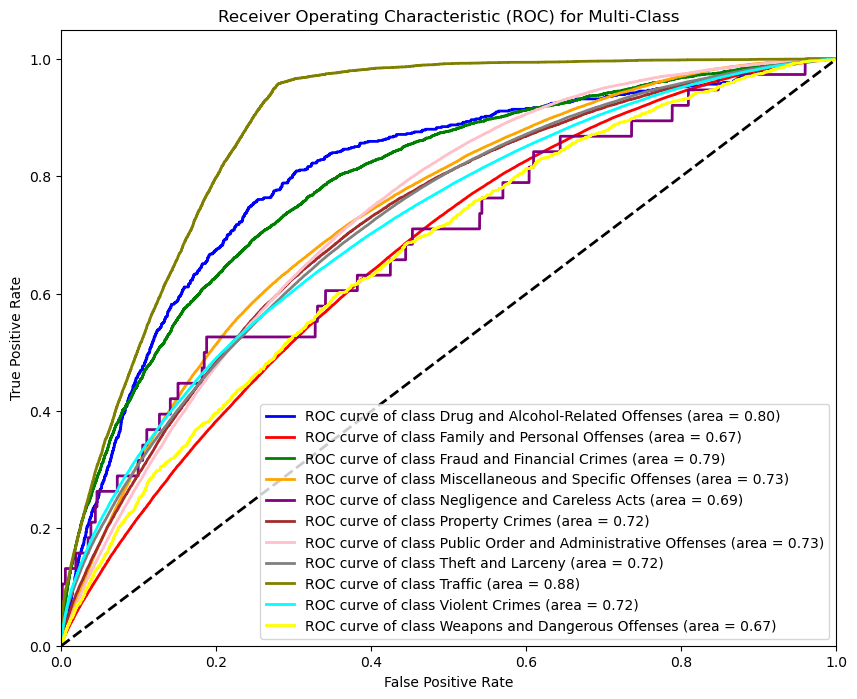

In [5]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=range(len(model.label_encoder.classes_)))

# Get the prediction probabilities from the model
y_score = model.pipeline.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'yellow']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {model.label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()


In [6]:
# ROC: graphical representation that illustrates the performance of a multi class classifier 
# system as its discrimination threshold is varied. 
# AUC: measures the classifier's ability to distinguish between classes

In [7]:
from sklearn.metrics import cohen_kappa_score

# Generate predictions on the test set if you haven't done so already
y_pred = model.predict(X_test)

# Calculate Cohen's Kappa score
kappa_score = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cohen's Kappa Score: 0.1902


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   17.3s finished


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score, cohen_kappa_score

# Define the K-Folds cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

def kappa_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return cohen_kappa_score(y, y_pred)

kappa_scorer = make_scorer(kappa_scorer)

# Assuming `model.pipeline` is your trained pipeline, and model.X and model.y are your data and labels
kappa_scores = cross_val_score(model.pipeline, model.X, model.y, cv=kf, scoring=kappa_scorer, n_jobs=-1)

# Output the cross-validated Kappa scores
print(f"K-Folds Cross-validated Cohen's Kappa scores: {kappa_scores}")
print(f"Mean Kappa Score: {kappa_scores.mean():.4f}")


# Using accuracy as the scoring metric
accuracy_scores = cross_val_score(model.pipeline, model.X, model.y, cv=kf, scoring='accuracy', n_jobs=-1)

print(f"K-Folds Cross-validated Accuracy scores: {accuracy_scores}")
print(f"Mean Accuracy: {accuracy_scores.mean():.4f}")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 70.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   16.0s finished
/Users/markfinlay/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/markfinlay/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/markfinlay/anac

K-Folds Cross-validated Cohen's Kappa scores: [nan nan nan nan nan]
Mean Kappa Score: nan


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
# Kappa Score - Accounting for chance in predictions 
# 0.1873 - Poor agreement
# This score suggests that your model's predictive performance is relatively low in terms of 
# agreement with the actual labels, considering the possibility of random chance.

# Further work
# Address Class Imbalance - oversampling the minority classes, undersampling the majority classes
# Feature Engineering - add more features from other datasets using MongoHandler pattern
# Hyperparameter Tuning - RandomizedSearchCV to find the optimal hyperparameters for RandomForest model.
# Use Other Models - Gradient Boosting, XGBoost, or Neural Networks


# Comments
# Liberal Classifier